In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-05 22:42:05.206269: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-05 22:42:05.211431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-05 22:42:05.211445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

### Loading the Full prepared dataset - Fakeddit

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")
final_df=final_df.dropna()

#### Splitting Data into Train and Test Datasets

In [3]:
train, test = train_test_split(final_df[['fulltext','class']], test_size=0.3,stratify=final_df['class'], random_state=0)

###### Due to huge data size and memory constraint issues, here we are considering  50% training part from the full training part 

In [4]:
train_filtered = train.sample(frac=.5)
test_filtered = test.sample(frac=.5)

train_filtered=train_filtered.reset_index(drop=True)
test_filtered=test_filtered.reset_index(drop=True)


X_train=train_filtered[['fulltext']]
y_train=train_filtered[['class']]

X_test=test_filtered[['fulltext']]
y_test=test_filtered[['class']]

In [5]:
y_train.value_counts()

class
1        116097
0         51767
dtype: int64

In [6]:
y_test.value_counts()

class
1        49796
0        22146
dtype: int64

### BERT Embedding Layer

In [7]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

2022-07-05 22:43:26.342411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-05 22:43:26.342779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-05 22:43:26.343103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [8]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

- input token ids is tokenizer converts tokens using vocab file.
- input masks are either 0 or 1. 1 for useful tokens, 0 for padding.
- segment ids are either 0 or 1. For 2 text training: 0 for the first one, 1 for the second one.

In [9]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs

In [10]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [11]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Tokenisation

In [12]:
#Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
#Instantiate Tokenizer with vocab
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

### Helper function to create bert input array format for the given sentences

In [13]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

In [14]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

test_sentences=X_test.fulltext.values
test_y = y_test.values
test_inputs=create_input_array(test_sentences)

100%|██████████| 71942/71942 [00:37<00:00, 1900.46it/s]


In [15]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

    
def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


In [16]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(5, 5), dpi=80)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

### CNN

In [30]:
# Model Checkpoint and EarlyStopping
filepath_cnn = "outputs//model_FAKEDDIT_CNN_BERT_V1.h5" # Location to get the model
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_cnn = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_cnn = [checkpoint_cnn,es_cnn]

In [31]:
x= tf.keras.layers.Conv1D(256,kernel_size=3,padding='valid', activation='relu')(sequence_output)
x= tf.keras.layers.Conv1D(128,kernel_size=3,padding='valid', activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

cnn_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       multiple             109482241   ['input_word_ids[0][0]',         
                                                                  'input_mask[0][0]',         

In [32]:
clear_session()

In [ ]:
history_cnn_bert=cnn_model.fit(train_inputs,train_y,epochs=2,batch_size=128,validation_split=0.2,
                               shuffle=True, callbacks=callbacks_list_cnn) 

In [ ]:
#Prediction
y_pred=cnn_model.predict(test_inputs)
ytrue = y_test.astype(int).tolist()
y_pred = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred)
recall = recall_score(ytrue, y_pred)
f1score = f1_score(ytrue, y_pred)
history_cnn_word2vec.history['precision']=precision
history_cnn_word2vec.history['recall']=recall
history_cnn_word2vec.history['f1score']=f1score
hist_df = pd.DataFrame(history_cnn_word2vec.history) 
hist_df.to_csv("outputs//model_FAKEDDIT_CNN_BERT_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("CNN Completed")


Training Accuracy : 0.9432985782623292
Validation Accuracy : 0.917841136455536
Precision : 0.9307542070271656
Recall : 0.947407526406683
F1 Score : 0.9390070357359658


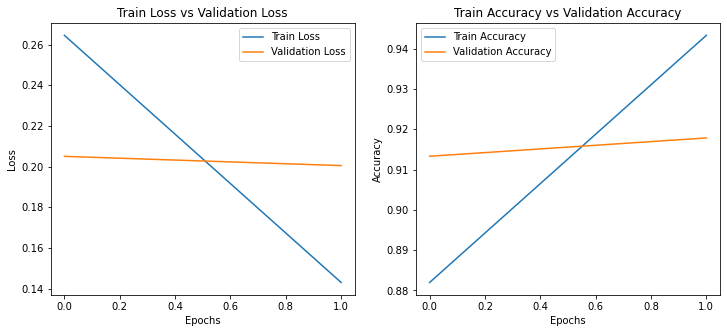

In [19]:
hist_df = pd.read_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_CNN_BERT_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

##### Prediction

In [16]:
from tensorflow.keras.models import load_model
new_model = load_model('outputs//fakeddit_dl_bert//model_FAKEDDIT_CNN_BERT_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [26]:
y_pred=new_model.predict(test_inputs)
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

2249/2249 [==============================] - 1911s 850ms/step


In [27]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)


Accuracy score : 0.91493147257513
precision = 0.9320820395166235
recall = 0.9460783329652902
f1score = 0.9390280351485446


In [28]:
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

[[18695  3434]
 [ 2686 47127]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     22129
           1       0.93      0.95      0.94     49813

    accuracy                           0.91     71942
   macro avg       0.90      0.90      0.90     71942
weighted avg       0.91      0.91      0.91     71942



In [74]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_CNN_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.874374,0.844819,0.859343,22129.000000
1,0.932082,0.946078,0.939028,49813.000000
accuracy,0.914931,0.914931,0.914931,0.914931
macro avg,0.903228,0.895449,0.899185,71942.000000
weighted avg,0.914331,0.914931,0.914517,71942.000000


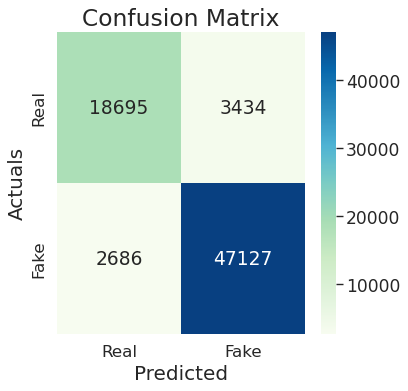

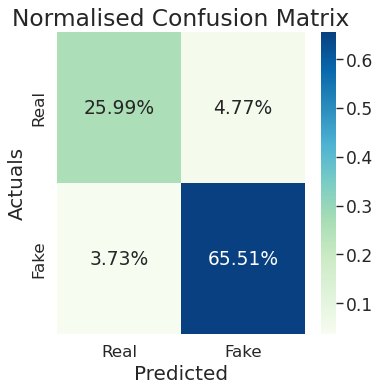

In [73]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_bert//fakeddit_cnn_cmtrx.png"
path2="outputs//fakeddit_dl_bert//fakeddit_cnn_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

In [68]:
# from IPython import display
# display.Image("outputs//cfm2222.png")

## LSTM

In [5]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "outputs//model_FAKEDDIT_LSTM_BERT.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

NameError: name 'ModelCheckpoint' is not defined

In [6]:
x= tf.keras.layers.LSTM(256)(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

lstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])
lstm_model.summary()

NameError: name 'tf' is not defined

In [7]:
clear_session()

NameError: name 'clear_session' is not defined

In [29]:
history_lstm_bert=lstm_model.fit(train_inputs,train_y,epochs=2,batch_size=256,validation_split=0.2,
                                 shuffle=True, callbacks=callbacks_list_lstm) 

Epoch 1/2
   4/2099 [..............................] - ETA: 5:41:28 - loss: 0.5600 - accuracy: 0.7109

KeyboardInterrupt: 

In [ ]:
y_pred=lstm_model.predict(test_inputs)
ytrue = y_test.astype(int).tolist()
y_pred = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred)
recall = recall_score(ytrue, y_pred)
f1score = f1_score(ytrue, y_pred)
history_lstm_bert.history['precision']=precision
history_lstm_bert.history['recall']=recall
history_lstm_bert.history['f1score']=f1score
hist_df = pd.DataFrame(history_lstm_bert.history)  
hist_df.to_csv("outputs//model_FAKEDDIT_LSTM_BERT_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("LSTM Completed")

Training Accuracy : 0.9457521438598632
Validation Accuracy : 0.917016625404358
Precision : 0.9484375320598314
Recall : 0.9275036619379176
F1 Score : 0.9378537951183882


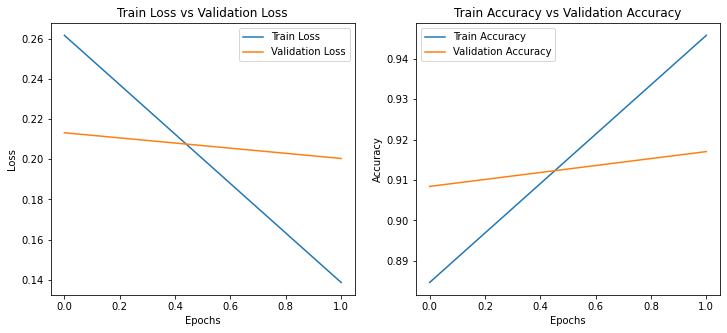

In [20]:
hist_df = pd.read_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_LSTM_BERT_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

#### Prediction

In [75]:
from tensorflow.keras.models import load_model
new_model = load_model('outputs//fakeddit_dl_bert//model_FAKEDDIT_LSTM_BERT_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [76]:
y_pred=new_model.predict(test_inputs)
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 2247s 998ms/step


In [77]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.91493147257513
precision = 0.9489714133048357
recall = 0.9269869311223977
f1score = 0.9378503533999513
[[19646  2483]
 [ 3637 46176]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     22129
           1       0.95      0.93      0.94     49813

    accuracy                           0.91     71942
   macro avg       0.90      0.91      0.90     71942
weighted avg       0.92      0.91      0.92     71942



In [78]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_LSTM_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.843792,0.887794,0.865234,22129.000000
1,0.948971,0.926987,0.937850,49813.000000
accuracy,0.914931,0.914931,0.914931,0.914931
macro avg,0.896382,0.907391,0.901542,71942.000000
weighted avg,0.916619,0.914931,0.915514,71942.000000


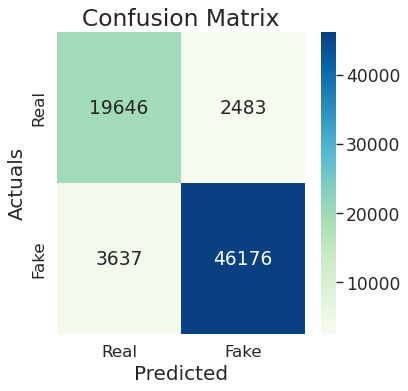

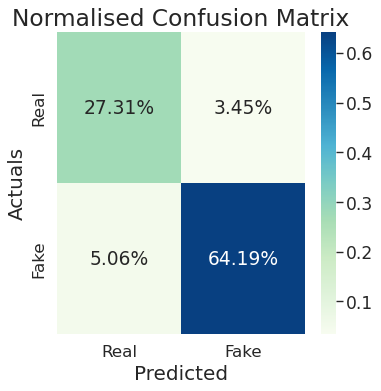

In [79]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_bert//fakeddit_lstm_cmtrx.png"
path2="outputs//fakeddit_dl_bert//fakeddit_lstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

In [82]:
# from IPython import display
# display.Image("outputs//fakeddit_dl_bert//fakeddit_lstm_cmtrx.png")

### BILSTM

In [17]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "outputs//model_FAKEDDIT_BILSTM_BERT.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [18]:
clear_session()

In [19]:
x= tf.keras.layers.Bidirectional(LSTM(256))(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

bilstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

bilstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [ ]:
history_bilstm_bert=bilstm_model.fit(train_inputs,train_y,epochs=2,batch_size=256,validation_split=0.2,shuffle=True, 
                                     callbacks=callbacks_list_bilstm) 

In [ ]:
y_pred=bilstm_model.predict(test_inputs)
ytrue = y_test.astype(int).tolist()
y_pred = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred)
recall = recall_score(ytrue, y_pred)
f1score = f1_score(ytrue, y_pred)
history_bilstm_bert.history['precision']=precision
history_bilstm_bert.history['recall']=recall
history_bilstm_bert.history['f1score']=f1score 
hist_df = pd.DataFrame(history_bilstm_bert.history) 
hist_df.to_csv("outputs//model_FAKEDDIT_BILSTM_BERT_history.csv",index=False)

Training Accuracy : 0.9956735968589784
Validation Accuracy : 0.9159145951271056
Precision : 0.9263590144700822
Recall : 0.9505788871721812
F1 Score : 0.9383126850668966


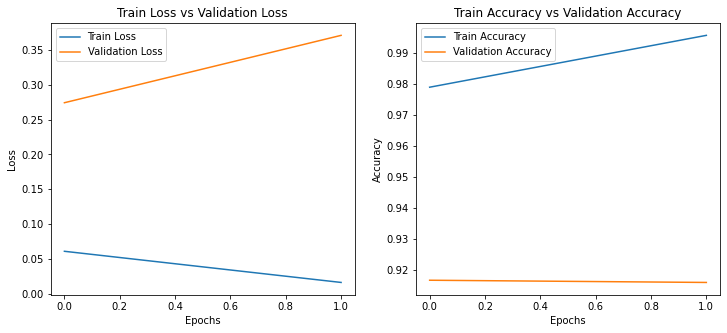

In [21]:
hist_df = pd.read_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_BILSTM_BERT_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

#### Prediction

In [20]:
from tensorflow.keras.models import load_model
new_model = load_model('outputs//fakeddit_dl_bert//model_FAKEDDIT_BILSTM_BERT_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [21]:
y_pred=new_model.predict(test_inputs)
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 2113s 938ms/step


In [22]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9129576603374941
precision = 0.9260119896116069
recall = 0.950435915422387
f1score = 0.9380650010879671
[[18258  3789]
 [ 2473 47422]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     22047
           1       0.93      0.95      0.94     49895

    accuracy                           0.91     71942
   macro avg       0.90      0.89      0.90     71942
weighted avg       0.91      0.91      0.91     71942



In [23]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_bert//model_FAKEDDIT_BILSTM_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.880710,0.828140,0.853616,22047.000000
1,0.926012,0.950436,0.938065,49895.000000
accuracy,0.912958,0.912958,0.912958,0.912958
macro avg,0.903361,0.889288,0.895841,71942.000000
weighted avg,0.912129,0.912958,0.912185,71942.000000


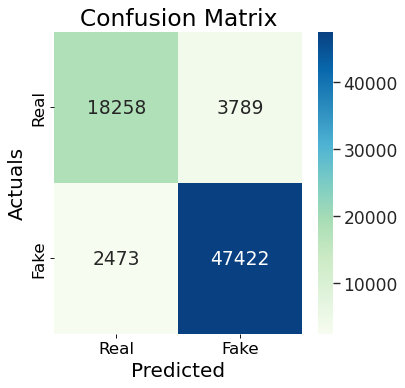

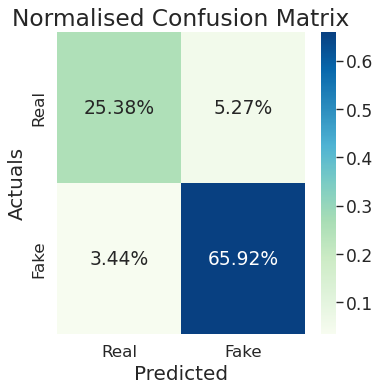

In [24]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_bert//fakeddit_bilstm_cmtrx.png"
path2="outputs//fakeddit_dl_bert//fakeddit_bilstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Error Analysis

In [28]:
train, test = train_test_split(final_df[['fulltext','class']], test_size=0.3,
                               stratify=final_df['class'], random_state=0)

In [29]:
test_filtered = test.sample(frac=.5)

X_test=test_filtered[['fulltext']]
y_test=test_filtered[['class']]

In [30]:
test_sentences=X_test.fulltext.values
test_y = y_test.values
test_inputs=create_input_array(test_sentences)

100%|██████████| 71942/71942 [00:55<00:00, 1297.57it/s]


In [31]:
from tensorflow.keras.models import load_model
new_model = load_model('outputs//fakeddit_dl_bert//model_FAKEDDIT_BILSTM_BERT_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [32]:
y_pred=new_model.predict(test_inputs)
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 3599s 2s/step


In [34]:
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9124711573211753
precision = 0.9249188152901131
recall = 0.9505619332917831
f1score = 0.9375650673726168
[[18365  3838]
 [ 2459 47280]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     22203
           1       0.92      0.95      0.94     49739

    accuracy                           0.91     71942
   macro avg       0.90      0.89      0.90     71942
weighted avg       0.91      0.91      0.91     71942



In [35]:
len(y_pred)

71942

In [36]:
len(ytrue)

71942

In [37]:
#### Helper function to extract actual domain name
def domain_extract(text):
    extrt_url = tldextract.extract(text)
    return extrt_url.domain


In [25]:
#final_df['domain']=final_df['domain'].apply(domain_extract)

In [27]:
test_filtered.shape

(71942, 3)

In [26]:
#combining predictions with truth class labels in test_filtered dataframe
test_filtered.insert(len(test_filtered.columns),'pred',y_pred2)
test_filtered.head(2)

,fulltext,class,pred
0,tree branch way too long picture wierd earth bend warms center wow look camera setup taken republic gilead,0,0
1,passed out dan harmon imgur rczhw jpg imgur opjou jpg,1,1


In [38]:
#combining predictions with truth class labels in test_filtered dataframe
test_filtered.insert(len(test_filtered.columns),'pred',y_pred2)
test_filtered.head(2)

,fulltext,class,pred
389736,this pizza place is sending mixed messages fugly pizza,1,0
7038,kanye smiling http imgur zzbjm jpg mirrored horizontally easier switch small logo jacket one http imgur ypejv,1,1


In [39]:
#test_filtered.to_csv('outputs//testing//test_filtered.csv')

In [46]:
# ss=pd.read_csv('outputs//testing//test_filtered.csv')
# ss.set_index('Unnamed: 0', inplace=True)
# ss.rename_axis('')
# ss.head(2)

,fulltext,class,pred
Unnamed: 0,,,
389736,this pizza place is sending mixed messages fugly pizza,1,0
7038,kanye smiling http imgur zzbjm jpg mirrored horizontally easier switch small logo jacket one http imgur ypejv,1,1


In [40]:
#misclassified samples
df = final_df.loc[test_filtered[test_filtered['class']!=test_filtered['pred']].index, :]  # works
df.shape

(6297, 10)

In [74]:
#df.to_csv('outputs//testing//misclassified.csv')
#final_df.to_csv('outputs//testing//final_df.csv')

In [47]:
X_testtt_base = final_df.loc[test_filtered.index, :]  # works

In [48]:
X_testtt_base.shape

(71942, 10)

In [49]:
df['domain']=df['domain'].apply(domain_extract)
X_testtt_base['domain']=X_testtt_base['domain'].apply(domain_extract)

In [50]:
df['class'].value_counts()

0    3838
1    2459
Name: class, dtype: int64

#### Misclassified or wrong predictions of  news count with Domain Based 

In [56]:
df_domain_misclassfd_count=df.pivot_table(index = 'domain', columns = 'class', values = 'submission_id', 
                                          aggfunc='count').fillna(0).astype(int)

In [68]:
wrongpred_real_domain=df_domain_misclassfd_count[0].sort_values(ascending=False).head(15)
wrongpred_fake_domain=df_domain_misclassfd_count[1].sort_values(ascending=False).head(15)

In [69]:
#df_domain_misclassfd_count[1].sort_values(ascending=False).head(15)

#### Misclassified Real news predictions based on domain

<AxesSubplot:xlabel='domain'>

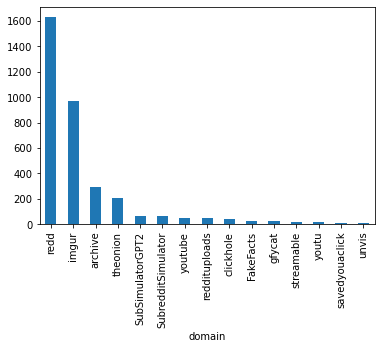

In [70]:
wrongpred_real_domain.plot(kind='bar')

#### Misclassified Fake news predictions based on domain

<AxesSubplot:xlabel='domain'>

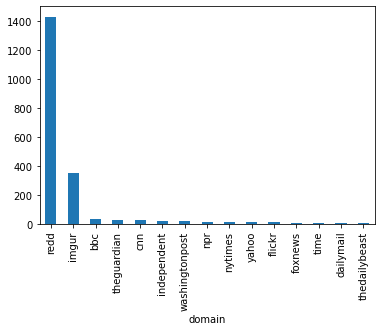

In [71]:
wrongpred_fake_domain.plot(kind='bar')

In [79]:
df_domain_misclassfd_count.sort_values(by=0,ascending=False).head(15)

class,0,1
domain,,
redd,1629,1428
imgur,973,346
archive,293,0
theonion,206,0
SubSimulatorGPT2,69,0
SubredditSimulator,67,0
youtube,48,5
reddituploads,47,3
clickhole,40,0


#### Igoring the common domain misclassifieds

<AxesSubplot:xlabel='domain'>

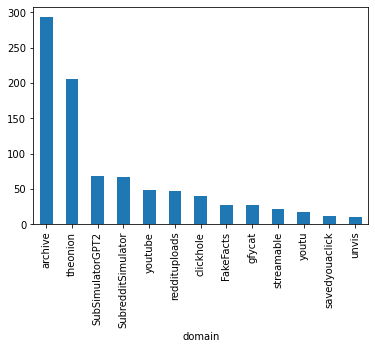

In [84]:
wrongpred_real_domain.iloc[2::].plot(kind='bar')

<AxesSubplot:xlabel='domain'>

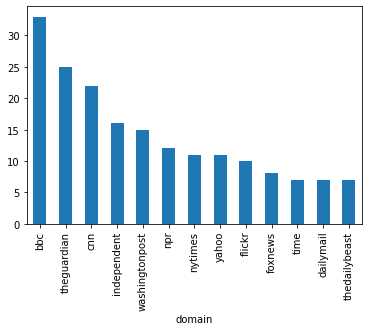

In [85]:
wrongpred_fake_domain.iloc[2::].plot(kind='bar')

### Error Analysis Based on Subreddit Category

In [124]:
a=X_testtt_base.subreddit.value_counts()
a=a.rename("total_count", inplace = True)

mildlyinteresting        15224
nottheonion              13991
photoshopbattles         13882
fakehistoryporn           4046
upliftingnews             3790
pareidolia                3683
subredditsimulator        2951
fakealbumcovers           2778
misleadingthumbnails      2139
propagandaposters         2084
confusing_perspective     2083
savedyouaclick            1315
neutralnews               1144
pic                        731
subsimulatorgpt2           517
usnews                     489
usanews                    488
theonion                   440
satire                     127
fakefacts                   39
waterfordwhispersnews        1
Name: total_count, dtype: int64

In [125]:
a.head()

mildlyinteresting    15224
nottheonion          13991
photoshopbattles     13882
fakehistoryporn       4046
upliftingnews         3790
Name: total_count, dtype: int64

In [126]:
b=df.subreddit.value_counts()
b=b.rename("error_count", inplace = True)

In [127]:
b.head()

mildlyinteresting        1521
pareidolia                860
misleadingthumbnails      516
confusing_perspective     477
fakehistoryporn           418
Name: error_count, dtype: int64

In [128]:
combined_df=pd.concat([a, b],axis=1)

In [130]:
combined_df['error_percentage']=(combined_df['error_count']/combined_df['total_count'])*100

In [133]:
combined_df.sort_values(by='error_percentage',ascending=False).head(15)

,total_count,error_count,error_percentage
waterfordwhispersnews,1,1,100.000000
fakefacts,39,27,69.230769
satire,127,82,64.566929
theonion,440,259,58.863636
savedyouaclick,1315,403,30.646388
subsimulatorgpt2,517,155,29.980658
pic,731,214,29.274966
misleadingthumbnails,2139,516,24.123422
pareidolia,3683,860,23.350529
confusing_perspective,2083,477,22.899664
